In [1]:

from dotenv import load_dotenv
from typing import Literal
from typing_extensions import TypedDict 

# LangChain 및 LangGraph 관련 라이브러리
from langchain.prompts.chat import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage, AIMessage

from langgraph.types import Command
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import create_react_agent

from langsmith import utils 
from langchain_openai import ChatOpenAI

from agents.agent_library import agent_configs
from team_graph.report_team_subgraph import report_graph
from team_graph.general_chat_subgraph import general_graph
from team_graph.insider_team_graph import insider_graph 
from team_graph.analyst_team_graph import analyst_graph
# 환경 변수 로드
load_dotenv()
print(utils.tracing_is_enabled())

True


In [2]:
class AgentState(MessagesState):
    query: str


In [3]:
llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18")
data_team_leader_llm  = ChatOpenAI(model="gpt-4o-mini-2024-07-18")

In [4]:
# 시장 조사 에이전트
news_and_sentiment_retrieval_agent = create_react_agent(
    llm, 
    tools=agent_configs['news_and_sentiment_retrieval_agent']['tools'],
    prompt=agent_configs['news_and_sentiment_retrieval_agent']['prompt']
)

market_data_retrieval_agent = create_react_agent(
    llm, 
    tools=agent_configs['market_data_retrieval_agent']['tools'], 
    prompt = agent_configs['market_data_retrieval_agent']['prompt']
)


economic_data_retrieval_agent = create_react_agent(
    llm, 
    tools=agent_configs['economic_data_retrieval_agent']['tools'], 
    prompt=agent_configs['economic_data_retrieval_agent']['prompt']
)


financial_statement_retrieval_agent = create_react_agent(
    llm,
    tools=agent_configs['financial_statement_retrieval_agent']['tools'],
    prompt = agent_configs['financial_statement_retrieval_agent']['prompt']
)


data_retrieval_team_members=agent_configs['data_retrieval_leader_agent']['members']
data_retrieval_options_for_next = data_retrieval_team_members + ["FINISH"]
data_retrieval_leader_system_prompt = agent_configs['data_retrieval_leader_agent']['prompt']
data_retrieval_leader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", data_retrieval_leader_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next? "
            "Or should we FINISH? Select one of: {options}. "
        ),
    ]
).partial(options=str(data_retrieval_options_for_next), members=", ".join(data_retrieval_team_members))


supervisor_members = agent_configs['supervisor']['members']
supervisor_options_for_next = supervisor_members + ["FINISH"]
supervisor_system_prompt = agent_configs['supervisor']['prompt']
supervisor_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", supervisor_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next? "
            "Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(supervisor_options_for_next), members=", ".join(supervisor_members))


In [5]:
def news_and_sentiment_retrieval_node(state: AgentState) -> Command[Literal["data_team_leader"]]:
    """
    금융 뉴스 및 애널리스트 의견 수집

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    # 시장 조사 에이전트를 호출하여 결과를 얻습니다.
    result = news_and_sentiment_retrieval_agent.invoke(state)
    
    # 결과 메시지를 업데이트하고 supervisor node로 이동합니다.
    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='news_and_sentiment_retrieval')]},
        goto='data_team_leader'
    )



In [6]:
def market_data_retrieval_node(state: AgentState) -> Command[Literal["data_team_leader"]]:
    """
    실시간 주가 및 거래량 수집
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    result = market_data_retrieval_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='market_data_retrieval')]},
        goto='data_team_leader'
    )

In [7]:
def economic_data_retrieval_node(state: AgentState) -> Command[Literal["data_team_leader"]]:
    """
    거시경제 데이터(GDP, 금리, 인플레이션) 수집
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    result = economic_data_retrieval_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='economic_data_retrieval')]},
        goto='data_team_leader'
    )

In [8]:
def financial_statement_retrieval_node(state: AgentState) -> Command[Literal["data_team_leader"]]:
    """
    회사 재무 보고서와 주요 사건 관련 자료를 조사하는 노드.
    손익계산서 데이터와 재무 및 주요 사건 관련 SEC 보고서를 처리합니다.

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor 노드로 이동하기 위한 명령을 반환
    """
    result = financial_statement_retrieval_agent.invoke(state)
    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='financial_statement_retrieval')]},
        goto='data_team_leader'
    )


In [9]:
class DataTeamRouter(TypedDict):
    """Worker to route to next. If no workers needed or question is vague, route to FINISH."""
    next: Literal[*data_retrieval_options_for_next]


def data_team_leader_node(state: AgentState) -> Command[Literal[*data_retrieval_team_members, "reporter"]]:

    query = state['query']
    data_retrieval_team_chain = data_retrieval_leader_prompt | data_team_leader_llm.with_structured_output(DataTeamRouter)
    response= data_retrieval_team_chain.invoke({"messages" : state["messages"], "query" : query})


    goto = response["next"]

    if goto == "FINISH":
        goto = "reporter"  # 정상 종료 시

    
    return Command(goto=goto)


In [10]:
class Router(TypedDict):
    next: Literal[*supervisor_options_for_next]
    

def supervisor_node(state: AgentState) -> Command[Literal[*supervisor_members, END]]:
    """
    supervisor node 
    주어진 State를 기반으로 각 worker의 결과를 종합하고,
    다음에 수행할 worker를 결정
    모든 작업이 완료되면 analyst node로 이동

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: 다음에 수행할 worker 또는 analyst node로 이동하기 위한 명령 반환 
    """

    supervisor_chain = supervisor_prompt | llm.with_structured_output(Router)
    response= supervisor_chain.invoke(state)

    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto)

In [11]:
graph_builder = StateGraph(AgentState)

graph_builder.add_node("supervisor", supervisor_node)
graph_builder.add_node("news_and_sentiment_retrieval", news_and_sentiment_retrieval_node)
graph_builder.add_node("market_data_retrieval", market_data_retrieval_node)
graph_builder.add_node("financial_statement_retrieval", financial_statement_retrieval_node)
graph_builder.add_node("data_team_leader", data_team_leader_node)
graph_builder.add_node("economic_data_retrieval", economic_data_retrieval_node)
graph_builder.add_node("insider_team_leader", insider_graph)
graph_builder.add_node("reporter", report_graph)
graph_builder.add_node("general_team_leader", general_graph)
graph_builder.add_node("analyst_team_leader", analyst_graph)

graph_builder.add_edge(START, "supervisor")
graph_builder.add_edge("insider_team_leader", "data_team_leader")
graph_builder.add_edge("analyst_team_leader", "reporter")
graph_builder.add_edge("reporter", END)
graph_builder.add_edge("general_team_leader", END)

graph = graph_builder.compile()


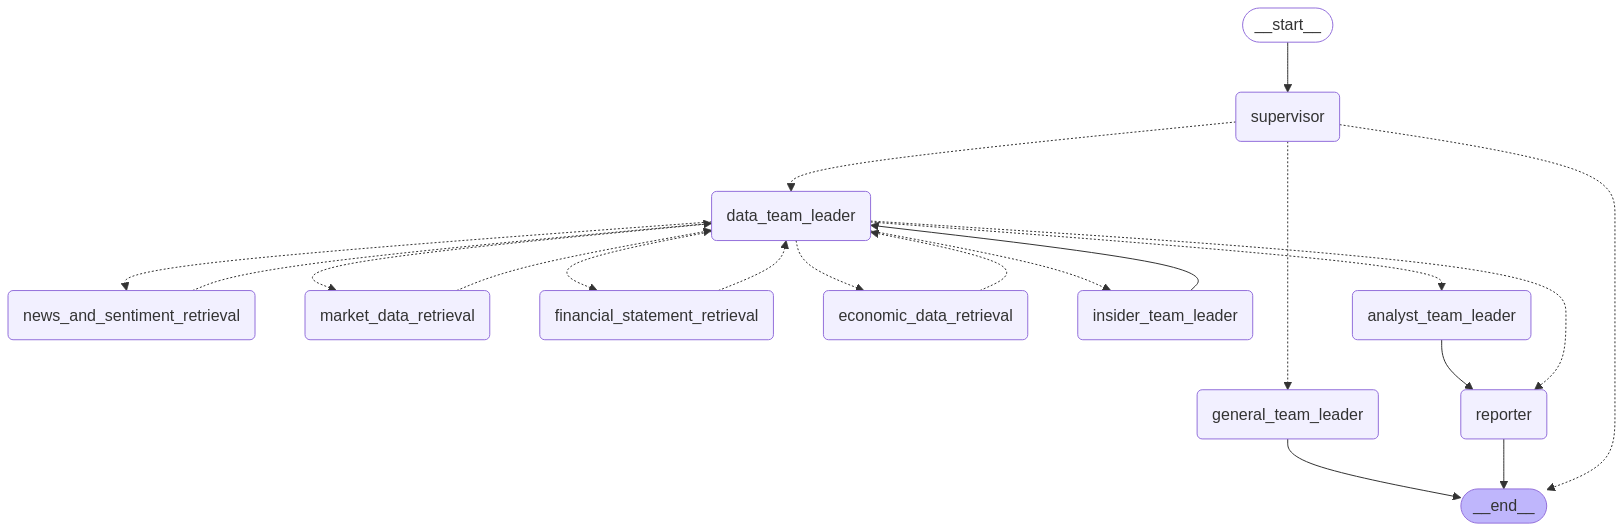

In [12]:
graph

In [ ]:
query =  "김치찌개 만드는법"
for chunk in graph.stream(
    {"messages": [("user",query)], "query" :query}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

In [13]:
query =  "최근 주식가격이 제일 많이 떨어진 종목은 뭐냐"
for chunk in graph.stream(
    {"messages": [("user",query)], "query" :query}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

최근 주식가격이 제일 많이 떨어진 종목은 뭐냐
================================ Human Message =================================
Name: market_data_retrieval

최근 주식 가격이 많이 떨어진 특정 종목에 대한 정보를 제공하려면, 특정 기간 또는 특정 종목에 대한 데이터가 필요합니다. 특정 종목을 제공해 주시면 그 종목의 최근 주식 가격 데이터를 검색하겠습니다. 또는 관심 있는 주식 티커를 알려주시면 해당 주식의 가격 변동을 확인하겠습니다.
================================ Human Message =================================
Name: news_and_sentiment_retrieval

최근 주식 시장에서 많은 주식들이 하락세를 보였습니다. 특히 **2025년 4월 7일**에는 다음과 같은 뉴스들이 주요하게 보도되었습니다:

1. **S&P 500**과 **Dow Jones**가 각각 350포인트 이상 하락하였으며, 이는 주간 기준으로 팬데믹 이후 최악의 성적이었습니다. 
   - [자세한 내용](https://finance.yahoo.com/news/live/stock-market-today-dow-sinks-350-points-sp-500-falls-for-third-day-as-tariffs-send-stocks-on-roller-coaster-200044633.html) (2025-04-07)

2. **SPY**와 **VOO**는 시장에서 약세장 영역에 진입하였습니다.
   - [자세한 내용](http://www.etf.com/sections/news/stock-bond-etfs-react-tariff-news-voo-hits-bear-market?utm_source=

In [13]:
query =  "최근 내부자가 가장 많은 지분을 매수한 상장사는 어디야"
for chunk in graph.stream(
    {"messages": [("user",query)], "query" :query}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

최근 내부자가 가장 많은 지분을 매수한 상장사는 어디야
================================ Human Message =================================
Name: domestic_insider_researcher

상장사의 내부자 주식 매수 활동을 확인하기 위해서는 구체적인 날짜 범위를 지정할 필요가 있습니다. 최근 1개월, 3개월, 6개월 중 어떤 기간을 원하시는지 알려주시면, 해당 기간 동안 내부자 지분 매수 활동이 가장 활발했던 상장사를 확인해 드릴 수 있습니다.
================================== Ai Message ==================================

제공된 정보로는 최근 상장사의 내부자 지분 매수 활동에 대한 구체적인 데이터를 확인할 수 없습니다. 내부자 주식 매수 활동을 파악하기 위해서는 특정한 날짜 범위가 필요합니다. 제일 최근 1개월, 3개월, 6개월 중 어떤 기간을 원하시나요? 해당 기간을 알려주시면, 내부자가 가장 활발하게 매수한 상장사를 확인하는 데 도움이 될 수 있습니다.


In [14]:
query =  "하이"
for chunk in graph.stream(
    {"messages": [("human",query)], "query" :query}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

하이
================================ Human Message =================================

안녕하세요! 무엇을 도와드릴까요? 금융 외 질문에 대한 답변은 정확도가 떨어질 수 있다는 점을 인지해주세요.


In [15]:
query =  "너는 미국주식에 특화되어있냐"
for chunk in graph.stream(
    {"messages": [("user",query)], "query" :query}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

너는 미국주식에 특화되어있냐
================================ Human Message =================================

네, finbrain은 미국 주식에 특화되어 있으며, SEC Filing 데이터, 주가 정보, 뉴스 및 경제 지표를 활용하여 투자 결정을 지원합니다.


In [16]:
query =  "무슨 질문에 대답할수있냐"
for chunk in graph.stream(
    {"messages": [("user",query)], "query" :query}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

무슨 질문에 대답할수있냐
================================ Human Message =================================

finbrain은 미국 주식에 관한 다양한 질문에 답변할 수 있습니다. 예를 들어, 특정 주식의 분석, 시장 동향, 기업의 재무 상태, SEC Filing 데이터, 뉴스 영향 등을 포함한 정보 제공이 가능합니다. 투자 결정을 위한 유용한 통찰을 얻는 데 도움을 줄 수 있습니다.


In [34]:
query =  "너는 바보냐"
for chunk in graph.stream(
    {"messages": [("user",query)], "query" :query}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

너는 바보냐
================================== Ai Message ==================================

제공된 정보는 특정한 질문에 대한 내용이 아니라 일반적인 질문입니다. 따라서 이에 대한 답변을 드릴 수 있는 데이터가 부족하다는 점을 알려드리겠습니다. 추가적인 질문이나 투자 관련 정보가 필요하시면 말씀해 주세요.


In [16]:
for chunk in graph.stream(
    {"messages": [("user", "최근 한달간 테슬라 내부자 거래가 있었는지 확인해줘")]}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

최근 한달간 테슬라 내부자 거래가 있었는지 확인해줘



KeyboardInterrupt



In [17]:
query= "오늘 테슬라 주가가 얼마냐"
for chunk in graph.stream(
    {"messages": [("user", query)], "query" : query}, stream_mode="values"
    ):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

오늘 테슬라 주가가 얼마냐
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


================================ Human Message =================================
Name: market_data_retrieval

오늘 테슬라(TSLA)의 주가는 다음과 같습니다:

- 종가: 245.38
- 고가: 248.86
- 저가: 241.70
- 시가: 245.05
- 거래량: 19,082,144
================================== Ai Message ==================================

오늘 테슬라(TSLA)의 주가는 다음과 같습니다:

- 종가: 245.38
- 고가: 248.86
- 저가: 241.70
- 시가: 245.05
- 거래량: 19,082,144


In [18]:
query = "지금 테슬라 주가 흐름이 어떻고 흐름에 영향을 끼치는 이슈가 뭔지 알려줘라"
for chunk in graph.stream(
    {"messages": [("user", query)], "query" : query}, stream_mode="values"
    ):
    chunk['messages'][-1].pretty_print()  

================================ Human Message =================================

지금 테슬라 주가 흐름이 어떻고 흐름에 영향을 끼치는 이슈가 뭔지 알려줘라


[*********************100%***********************]  1 of 1 completed



================================ Human Message =================================
Name: market_data_retrieval

현재 테슬라(TSLA)의 주가는 다음과 같습니다:

### 1일 주가 정보 (2025년 4월 8일)
- **종가 (Close)**: 244.95
- **고가 (High)**: 248.86
- **저가 (Low)**: 241.70
- **시가 (Open)**: 245.05
- **거래량 (Volume)**: 20,266,219

### 5일 주가 정보 (2025년 4월 8일)
- **종가 (Close)**: 244.95
- **고가 (High)**: 248.86
- **저가 (Low)**: 241.70
- **시가 (Open)**: 245.05
- **거래량 (Volume)**: 20,266,219

주가는 최근 5일간 큰 변동이 없으며, 현재 주가는 244.95입니다. 

주가에 영향을 미치는 특정 이슈에 대한 정보는 포함되어 있지 않으며, 전체적인 시장 동향, 생산 및 판매 수치, 신제품 발표, 경쟁사의 동향 등이 테슬라 주가에 영향을 미칠 수 있습니다.
================================ Human Message =================================
Name: news_and_sentiment_retrieval

현재 테슬라(TSLA)의 주가는 $244.95로 안정세를 보이고 있으며, 최근 1일 및 5일 동안 큰 변동이 없었습니다. 다음은 주가에 영향을 미치고 있는 주요 뉴스와 이슈들입니다:

1. **테슬라 주가 하락과 분석가 의견**  
   - **기사 제목**: [Tesla stock tumbles as bullish analyst throws in the towel, blaming tariffs and Elon Musk](https://finance.yahoo.com/news/tesla-stock-tumble

In [14]:
query = "최근 테슬라 내부자 매도가 있었나?"
for chunk in graph.stream(
    {"messages": [("user", query)], "query" : query}, stream_mode="values"
    ):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

최근 테슬라 내부자 매도가 있었나?
200
200
200
================================ Human Message =================================
Name: international_insider_researcher

최근 테슬라(차량 티커: TSLA)의 내부자 매도 내역은 다음과 같습니다:

1. **James R. Murdoch (Director)**
   - **거래일:** 2025-03-10
   - **매도 주식 수:** 54,776주
   - **주당 가격:** $240.788 (여러 가격에서 매도됨)
   - **매도 후 보유 주식 수:** 477,011주

2. **Vaibhav Taneja (CFO)**
   - **거래일:** 2025-03-06
   - **매도 주식 수:** 2,672.25주
   - **주당 가격:** $268.729
   - **매도 후 보유 주식 수:** 26,949.5주

3. **Vaibhav Taneja (CFO)**
   - **거래일:** 2025-03-03
   - **매도 주식 수:** 
     - 6,000주 (가중 평균가: $18.22)
     - 100주 (가중 평균가: $279.53)
     - 200주 (가중 평균가: $281.185)
     - 100주 (가중 평균가: $282.39)
     - 397주 (가중 평균가: $285.139)
     - 200주 (가중 평균가: $287.74)
     - 300주 (가중 평균가: $288.713)
     - 100주 (가중 평균가: $290.06)
     - 100주 (가중 평균가: $293.73)
     - 400주 (가중 평균가: $295.52)
     - 403주 (가중 평균가: $297.087)
     - 600주 (가중 평

In [15]:
query = "테슬라에 대한 기관 투자자들의 보유 비중이 최근에 어떻게 변했는지 보고 싶어."
for chunk in graph.stream(
    {"messages": [("user", query)], "query" : query}, stream_mode="values"
    ):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

테슬라에 대한 기관 투자자들의 보유 비중이 최근에 어떻게 변했는지 보고 싶어.
200
================================ Human Message =================================
Name: international_insider_researcher

최근 기관 투자자들의 테슬라(Tesla, Inc.)에 대한 보유 비중 변화를 정리한 내용은 다음과 같습니다:

1. **Elon R. Musk**
   - **보고서 유형**: SC 13G/A
   - **보고서 제출일**: 2024-02-14
   - **상장 주식 수**: 715,022,706 주
   - **소유 형태**: 모든 주식을 소유 및 투표권을 단독으로 보유

2. **Vanguard Group Inc**
   - **보고서 유형**: SC 13G/A
   - **보고서 제출일**: 2024-02-13
   - **상장 주식 비율**: 7.23%
   - **총 소유 주식 수**: 229,805,491 주
   - **소유 형태**: 일부 주식을 공유 소유, 일부 단독 보유

3. **BlackRock, Inc.**
   - **보고서 유형**: SC 13G/A
   - **보고서 제출일**: 2024-01-29
   - **상장 주식 비율**: 5.9%
   - **총 소유 주식 수**: 188,797,465 주
   - **소유 형태**: 단독으로 모든 주식 보유

이 데이터는 2023년 12월 기준으로 보유 비중이 보고되었으며, 기관 투자자들의 테슬라 주식 보유 현황에 대한 정보를 제공합니다.
================================== Ai Message ==================================

최근 기관 투자자들의 테슬라(Tesla, Inc.)에 대한 보유

In [17]:
query = "최근에 테슬라 대규모 지분을 확보하면서 경영 참여를 선언한 투자자가 있는지 알려줘."
for chunk in graph.stream(
    {"messages": [("user", query)], "query" : query}, stream_mode="values"
    ):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

최근에 테슬라 대규모 지분을 확보하면서 경영 참여를 선언한 투자자가 있는지 알려줘.
200
================================ Human Message =================================
Name: international_insider_researcher

최근 테슬라의 대규모 지분 확보와 관련하여 다음과 같은 주요 투자자의 보고서가 있습니다:

1. **The Vanguard Group, Inc.**
   - **보고서 유형**: SC 13G/A
   - **보고 날짜**: 2024-02-13
   - **이벤트 날짜**: 2023-12-29
   - **지분 비율**: 7.23%
   - **총 보유 주식 수**: 229,805,491 주
   - **독립 의결권**: 없음
   - **공동 의결권**: 3,719,744 주
   - **독립 결의권**: 217,847,966 주
   - **공동 결의권**: 11,957,525 주

2. **BlackRock, Inc.**
   - **보고서 유형**: SC 13G/A
   - **보고 날짜**: 2024-01-29
   - **이벤트 날짜**: 2023-12-31
   - **지분 비율**: 5.9%
   - **총 보유 주식 수**: 188,797,465 주
   - **독립 의결권**: 169,527,462 주
   - **공동 의결권**: 없음
   - **독립 결의권**: 188,797,465 주
   - **공동 결의권**: 없음

이 두 투자자는 최근 테슬라의 지분을 대규모로 확보하며 경영 참여 가능성을 시사하고 있습니다.


In [17]:
query = "종목 추천해줘"
for chunk in graph.stream(
    {"messages": [("user", query)], "query" : query}, stream_mode="values"
    ):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

종목 추천해줘
================================ Human Message =================================
Name: news_and_sentiment_retrieval

Based on recent expert recommendations, here are some stocks that are considered strong picks for 2025:

1. **Nvidia (NASDAQ: NVDA)**: With 37 "Buy" recommendations from analysts, Nvidia is a standout in the tech industry. The stock has an average price target of $177.08, representing a 31.86% upside from its current price of $134.29.

2. **Microsoft**: Frequently cited as a solid long-term investment, Microsoft continues to be a favorite among analysts.

3. **Apple**: Analysts have positive predictions for Apple, especially regarding its performance in the upcoming years.

These selections are based on expectations that these companies will perform well as the market evolves. If you would like more specific information about any of these companies or others, please let me know.
===

In [14]:
query = "미국 주식 추천해봐라"
for chunk in graph.stream(
    {"messages": [("user", query)], "query" : query}, stream_mode="values"
    ):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

미국 주식 추천해봐라
================================ Human Message =================================
Name: news_and_sentiment_retrieval

2025년에 주목해야 할 미국 주식 몇 가지를 소개합니다:

1. **테슬라 (Tesla, Inc.)** - 전기차 시장에서의 성장 가능성.
2. **엔비디아 (NVIDIA, NVDA)** - AI 반도체 시장의 선두주자로 데이터센터 및 자율주행 관련 기술력 보유.
3. **반도체 산업** - 지속적인 성장 가능성이 있는 분야로, 여러 관련 기업이 포함될 수 있음.
4. **바이오헬스** - 혁신적인 의료 기술 및 치료법 개발을 통해 성장할 가능성이 높은 산업.
5. **친환경 에너지** - 지속 가능성과 관련된 산업으로, 성장 잠재력이 큼.
6. **방위산업** - 안정적인 수요와 기술 개발이 계속될 것으로 예상.

이 리스트는 2025년의 시장 흐름과 투자 트렌드를 반영하여 선택된 주식들입니다.
================================ Human Message =================================
Name: data_cleansing

The provided data is a list of US stocks to watch in 2025, which aligns with the user's request for recommendations. Here is the cleaned dataset without any irrelevant content, duplicates, or inconsistencies:

1. **테슬라 (Tesla, Inc.)** - 전기차 시장에서의 성장 가능성.
2. **엔비디아 (NVIDIA, NVDA)** - AI 반도체

In [2]:
query = "근 1년간 삼성전자 내부자 거래 흐름 분석해라"
for chunk in graph.stream(
    {"messages": [("user", query)], "query" : query}, stream_mode="values"
    ):
    chunk['messages'][-1].pretty_print()

NameError: name 'graph' is not defined

In [14]:
query = "최근에 투자자 신뢰를 회복하려는 움직임이 있었떤 기업 알려줘"
for chunk in graph.stream(
    {"messages": [("user", query)], "query" : query}, stream_mode="values"
    ):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

최근에 투자자 신뢰를 회복하려는 움직임이 있었떤 기업 알려줘
================================ Human Message =================================
Name: news_and_sentiment_retrieval

최근 투자자 신뢰를 회복하려는 움직임이 있던 기업으로 **컬리**가 있습니다. 컬리는 2024년 1분기부터 금융감독원에 분기별 재무 및 비재무 항목을 공시하며, 상장 준비를 위해 주주가 500명을 초과하자 공시 의무가 생겼습니다. 임종룡 회장은 올해 경영전략 중 하나로 내부통제 혁신과 신뢰 회복을 강조하고 있습니다. 이는 지난해 금융사고로 인한 신뢰도 저하를 극복하기 위한 노력의 일환으로 보입니다.

금융당국 또한 투자자 신뢰 회복을 위해 다양한 조치를 취하고 있으며, IPO 제도의 개선을 통해 시장의 신뢰도를 높이기 위한 방안들을 추진하고 있습니다.U
================================== Ai Message ==================================

최근에 투자자 신뢰를 회복하려는 움직임이 있던 기업으로 **컬리**가 있습니다. 

컬리는 2024년 1분기부터 금융감독원에 분기별 재무 및 비재무 항목을 공시하며, 상장 준비를 위해 주주가 500명을 초과하자 공시 의무가 생겼습니다. 임종룡 회장은 올해 경영전략 중 하나로 내부통제 혁신과 신뢰 회복을 강조하고 있으며, 이는 지난해 금융사고로 인한 신뢰도 저하를 극복하기 위한 노력의 일환으로 보입니다.

또한, 금융당국 역시 투자자 신뢰 회복을 위해 다양한 조치를 취하고 있으며, IPO 제도의 개선을 통해 시장의 신뢰도를 높이기 위한 방안들을 추진하고 있습니다.


In [15]:
query = "최근에 경영진이 주주친화적ㅇ니 결정을 내린 회사가 있는지 찾아줘"
for chunk in graph.stream(
    {"messages": [("user", query)], "query" : query}, stream_mode="values"
    ):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

최근에 경영진이 주주친화적ㅇ니 결정을 내린 회사가 있는지 찾아줘
================================ Human Message =================================
Name: news_and_sentiment_retrieval

최근에 주주 친화적인 결정을 내린 몇 가지 회사와 관련된 사실을 아래에 제공합니다:

1. **Walt Disney Company (DIS)**
   - CEO Bob Iger는 2025년 주주총회에서 회사의 기술과 창의력을 결합한 전략에 대해 발표하였습니다.
   - 디즈니는 Fox의 부지에서 퇴거할 계획이 있으며, 2025년 연말까지 해당 부지를 비울 예정입니다. (출처: [Yahoo Finance](https://finance.yahoo.com/news/disney-plans-vacate-storied-fox-225415138.html), 2025-04-01)

2. **Paramount Global**
   - Deutsche Bank는 Paramount Global의 주식을 "Buy"에서 "Hold"로 하향 조정하였으며, 이는 낮은 수익 기대치와 광고 전망의 위험 증가 때문입니다. (출처: [Yahoo Finance](https://finance.yahoo.com/news/deutsche-bank-downgrades-paramount-global-150011775.html), 2025-04-02)

이 외에도 여러 기업들이 주주 친화적인 결정이나 변화를 모색하고 있으나, 구체적인 결정 내용은 다소 한정적입니다. 추가 정보를 원하신다면 특정 회사 혹은 주제에 대해 알려주시면 더 찾아보겠습니다.
================================ Human Message =================================
Na

In [14]:
query = "삼성전자 근 1년간 내부자 매도가 있었는지 확인해봐"
for chunk in graph.stream(
    {"messages": [("user", query)], "query" : query}, stream_mode="values"
    ):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

삼성전자 근 1년간 내부자 매도가 있었는지 확인해봐
================================ Human Message =================================
Name: domestic_insider_researcher

삼성전자에서 최근 1년간의 내부자 매도 활동은 다음과 같습니다:

1. **2025-03-21**
   - **보고자**: 이혁재 (사외이사)
   - **매도주식 수**: 200주

2. **2025-03-19**
   - **보고자**: 송상철 (상무)
   - **매도주식 수**: 1,500주

3. **2025-03-14**
   - **보고자**: 송상철 (상무)
   - **매도주식 수**: 2,500주

4. **2025-03-11**
   - **보고자**: 임전식 (상무)
   - **매도주식 수**: 280주

5. **2025-02-26**
   - **보고자**: 윤성호 (상무)
   - **매도주식 수**: 200주

6. **2025-02-06**
   - **보고자**: 최철환 (상무)
   - **매도주식 수**: 821주
   - **보고자**: 조미선 (상무)
   - **매도주식 수**: 2,772주

7. **2025-01-06**
   - **보고자**: 권혁우 (상무)
   - **매도주식 수**: 300주

이 외에도 여러 명의 내부자가 주식을 매도했으며, 각 매도 건수는 상기 목록에서 확인할 수 있습니다. 추가 정보가 필요하시면 말씀해 주세요.
================================ Human Message =================================
Name: data_cleansing

삼성전자에서 최근 1년간의 내부자 매도 활동은 다음과 같습니다:

1. **2025-03-21*

In [18]:
query = "테슬라 향후 주가가 어떻게 될까"
for chunk in graph.stream(
    {"messages": [("user", query)], "query" : query}, stream_mode="values"
    ):
    chunk['messages'][-1].pretty_print()  

================================ Human Message =================================

테슬라 향후 주가가 어떻게 될까
================================ Human Message =================================
Name: market_data_retrieval

미안하지만, 주가의 향후 변동에 대한 예측이나 의견을 제공할 수 없습니다. 대신, 테슬라의 현재 주가 정보를 원하시면 알려주세요.


[*********************100%***********************]  1 of 1 completed


================================ Human Message =================================
Name: market_data_retrieval

현재 테슬라(TSLA)의 주가 정보는 다음과 같습니다:

- 종가: 282.76 USD
- 고가: 284.99 USD
- 저가: 251.27 USD
- 시가: 254.60 USD
- 거래량: 209,746,300 주

이 정보는 2025년 4월 2일 기준입니다.
================================== Ai Message ==================================

죄송하지만, 테슬라의 향후 주가 변동에 대한 예측이나 의견을 제공할 수 없습니다. 대신, 현재 테슬라(TSLA)의 주가 정보는 다음과 같습니다:

- 종가: 282.76 USD
- 고가: 284.99 USD
- 저가: 251.27 USD
- 시가: 254.60 USD
- 거래량: 209,746,300 주

이 정보는 2025년 4월 2일 기준입니다. 추가적인 정보가 필요하시면 말씀해 주세요.


In [14]:
query = "삼성전자의 실적 발표 이후 시장 반응이 어떤가요? 투자해도 괜찮을까요?"
for chunk in graph.stream(
    {"messages": [("user", query)], "query" : query}, stream_mode="values"
    ):
    chunk['messages'][-1].pretty_print()  

================================ Human Message =================================

삼성전자의 실적 발표 이후 시장 반응이 어떤가요? 투자해도 괜찮을까요?
================================ Human Message =================================
Name: news_and_sentiment_retrieval

삼성전자는 2025년 1분기 잠정 실적 발표를 앞두고 있으며, 시장에서는 다음과 같은 반응과 기대가 나타나고 있습니다.

1. **AI 반도체 수요 증가**: AI 반도체와 관련한 수요가 급증하고 있어, 삼성전자의 반도체 부문 적자 폭이 줄어들 것이라는 기대가 커지고 있습니다. 이는 AI 서버용 고부가가치 메모리 수요 증가에 기인하고 있습니다.

2. **스마트폰 및 가전 부문**: 이러한 부문에서는 안정적인 실적 유지를 예상하고 있습니다. 특히 삼성전자는 HBM3 고성능 메모리의 확대 생산을 통해 경쟁력을 갖추고 있습니다.

3. **글로벌 데이터센터 투자**: 낸드플래시 가격이 반등하고 있으며, 이는 글로벌 데이터센터 투자 증가와 관련이 있습니다. 그러나 AI와 클라우드 수요가 전체 시장에 미치는 영향에서도 변동성이 존재하고 있습니다.

4. **실적 전망**: 2025년 삼성전자의 영업이익은 기존 예상보다 하향 조정되어 35.1조 원으로 예상되고 있으며, 이는 DRAM과 NAND 가격 하락 압력 때문입니다.

5. **장기적인 주가 회복 기대**: 삼성전자의 주가는 2025년에 긍정적인 실적 발표가 예상되며, 기술 혁신과 시장 리더십을 유지함으로써 상승할 가능성이 제기되고 있습니다. 주식 분석가들은 2025년 4월부터 5월까지 삼성전자가 주도하는 상승장이 펼쳐질 수 있다고 보고 있습니다.

결론적으로, 삼성전자가 반도체 시장에서 큰 점유율을 유지하고 있으며, 향후 AI 반도체 시장에서도 중요하게 작용할 것으로 기대되므로, 현재 시장 반

In [14]:
query = "최근 미국 금리 변화가 국내 증시에 어떤 영향을 줄 수 있을까요?"
for chunk in graph.stream(
    {"messages": [("user", query)], "query" : query}, stream_mode="values"
    ):
    chunk['messages'][-1].pretty_print()  

================================ Human Message =================================

최근 미국 금리 변화가 국내 증시에 어떤 영향을 줄 수 있을까요?
================================ Human Message =================================
Name: economic_data_retrieval

죄송하지만, 저는 데이터 제공자로서 공적인 정보만을 제공할 수 있습니다. 최근 미국 금리 변화에 대한 데이터나 지표를 제공할 수 있으니, 필요한 특정 지표(예: 금리, CPI, 실업률 등)를 말씀해 주시면 해당 데이터를 가져오겠습니다.
================================ Human Message =================================
Name: economic_data_retrieval

다음은 최근의 Core CPI (소비자물가지수) 데이터입니다:

1. **2025년 2월**
   - Core CPI: 325.475
   - 전년 대비 변화율 (YoY): 3.14%
   - 전월 대비 변화율 (MoM): 0.23%
   - 발표일: 2025년 3월 12일

2. **2025년 1월**
   - Core CPI: 324.739
   - 전년 대비 변화율 (YoY): 3.29%
   - 전월 대비 변화율 (MoM): 0.45%
   - 발표일: 2025년 2월 12일

3. **2024년 12월**
   - Core CPI: 323.296
   - 전년 대비 변화율 (YoY): 3.21%
   - 전월 대비 변화율 (MoM): 0.21%
   - 발표일: 2025년 1월 15일

4. **2024년 11월**
   - Core CPI: 322.619
   - 전년 대비 변화율 (YoY): 3.28%
   - 전월 대비 변화율 (MoM): 0.29%
   - 발표일: 2024년 12월 11일

5. **2024년